# Ejemplo 01: MODFLOW 2005 con flopy
## Luis M. de la Cruz
<font color=#FF0000>**Última actualización: lun ago 24 14:45:41 CDT 2020**</font>


En este ejemplo se muestra como usar las herramientas de flopy para crear un modelo de MODFLOW 2005 y ejecutarlo. Se verá cómo crear los datos de entrada y cómo definir los parámetros de salida de la simulación.


## Paso 1. Importar bibliotecas

Importamos las bibliotecas `numpy` y `flopy`.

In [1]:
import numpy as np
import flopy

flopy is installed in /home/luiggi/anaconda3/lib/python3.7/site-packages/flopy


## Paso 2. Inicializaciones
Definimos la ruta donde se encuentra el ejecutable de MODFLOW 2005 y el nombre de la simulación.

In [2]:
# WINDOWS (descomente la siguiente línea)
#mf2005_exe = 'C:\\Users\\luiggi\\Desktop\\MODFLOW\\MF2005.1_12\\bin\\mf2005.exe'

# LINUX (desocomente la siguiente línea)
mf2005_exe = '/home/luiggi/GitSites/MODFLOW/MF2005.1_12u/bin/mf2005'
# Definimos el nombre de la simulación
modelname = 'twri_comp'

print(' Ruta hacia el ejecutable de MODFLOW 2005 : {} '.format(mf2005_exe))
print(' Nombre de esta simulación: {}'.format(modelname))

 Ruta hacia el ejecutable de MODFLOW 2005 : /home/luiggi/GitSites/MODFLOW/MF2005.1_12u/bin/mf2005 
 Nombre de esta simulación: twri_comp


## Paso 3. Creación del modelo de modflow 2005

In [3]:
mf = flopy.modflow.Modflow(modelname, exe_name = mf2005_exe) 
print(mf)

MODFLOW 0 layer(s) 0 row(s) 0 column(s) 0 stress period(s)


## Paso 4. Modelo discreto.

Definición del dominio y de la malla del modelo, para crear un objeto para la discretización (<a href="https://modflowpy.github.io/flopydoc/mfdis.html">ModflowDis</a>):

In [ ]:
Lx = 75000.
Ly = 75000.
ztop = 200.
zbot = -450.
nlay = 3
nrow = 15
ncol = 15
delr = Lx/ncol
delc = Ly/nrow
#botm = np.array([200,-150,-200,-300,-350,-450])
laycbd = np.array([1,1,0])

In [ ]:
print(delc, delr, laycbd, sep='\n')

In [ ]:
# Modelo discreto
dis = flopy.modflow.ModflowDis(mf, 
                               nlay, nrow, ncol, 
                               delr = delr, delc = delc, 
                               top = ztop, botm = zbot,
                               laycbd=[1,1,0])

In [ ]:
print(mf)

In [ ]:
type(dis) 

In [ ]:
print(dis)

In [ ]:
mf.write_input()

## Paso 3. Basic Package
Creación de un objeto de flopy para representar el *MODFLOW Basic Package* (Más detalles en <a href="https://modflowpy.github.io/flopydoc/mfbas.html">BAS</a>). 

Para el modelo de este ejemplo se asignan valores constantes a la carga (head values) de 10.0 y 0.0 a la primera y última columna del modelo, en todas las capas. 


In [ ]:
ibound = np.ones((nlay, nrow, ncol))#, dtype=np.int32)
ibound[:, :, 0] = -1 
ibound[:, :, -1] = -1

ibound[:,4:8,4:8] = -1 # Definiendo un obstáculo

strt = np.ones((nlay, nrow, ncol))#, dtype=np.float32)
strt[:, :, 0] = 10.
strt[:, :, -1] = 0.
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

In [ ]:
print(ibound)

In [ ]:
print(strt)

In [ ]:
type(bas)

In [ ]:
print(bas)

## Paso 4. Layer-Property Flow Package

Asignamos propiedades a las capas del modelo usando el *Layer-Property Flow Package* (<a href="https://modflowpy.github.io/flopydoc/mflpf.html">mflpf</a>). Se asignan valores de 10.0 a la conductividad hidráhulica, horizontal y verticalmente. 

**NOTA**: Como no se especifica un valor para `laytyp`, Flopy usa el valor por omisión de 0, lo cual significa que este modelo será confinado.

In [ ]:
lpf = flopy.modflow.ModflowLpf(mf, hk=10., vka=10., ipakcb=53)

In [ ]:
type(lpf)

In [ ]:
print(lpf)

## Paso 5. Parámetros para la salida

Se definen los parámetros para la salida de la simulación (<a href="https://modflowpy.github.io/flopydoc/mfoc.html">mfoc</a>)

**NOTA**: se utiliza un diccionario para definir que salida será guardada para los correspondientes periodos de *stress* y pasos de tiempo. En este caso, la tupla `(0,0)` significa que el periodo 1 y el tiempo 1 serán guardados. 

In [ ]:
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)

In [ ]:
print(type(spd), type(oc), sep='\n')

In [ ]:
print(spd)

In [ ]:
print(oc)

## Paso 6. Algoritmo de solución

Definición del algoritmo de solución. En este caso se usa *Preconditioned Conjugate Gradient Package* 
(<a href="https://modflowpy.github.io/flopydoc/mfpcg.html">mfpcg</a>). En este caso se usarán todos los valores por omisión.

In [ ]:
pcg = flopy.modflow.ModflowPcg(mf)

In [ ]:
type(pcg)

In [ ]:
print(pcg)

## Paso 7. Escritura de datos de entrada

Escribir los datos de entrada del modelo en un archivo se logra de la manera siguiente:

In [ ]:
mf.write_input()

## Paso 8. Ejecución del modelo

El objeto del modelo, en este caso `mf`, tiene un método para ejecutar el modelo. Para que esto funcione, el ejecutable de MODFLOW debe estar localizado dentro de una ruta accesible. En este caso, la ruta completa al ejecutable está identificada con `mf2005_exe`.

In [ ]:
success, buff = mf.run_model()

In [5]:
# Se importa la herramienta para leer los archivos binarios.
import flopy.utils.binaryfile as bf

# Lectura de la salida de MODFLOW
hds = bf.HeadFile(modelname+'.hds')
head = hds.get_data()#totim=1.0)

# Alternativamente se puede usar lo siguiente para leer los datos
#times = hds.get_times()
#head = hds.get_data(totim=times[-1])

print(type(hds), type(head), sep='\n')

<class 'flopy.utils.binaryfile.HeadFile'>
<class 'numpy.ndarray'>


In [6]:
print(head)

[[[   0.           22.28474113   39.88772925   54.21897292   66.16171815
     76.30942325   85.04555747   92.54708945   98.91380785  104.22900766
    108.571322    112.00662493  114.57583707  116.29196868  117.15249252]
  [   0.           21.89827766   39.1967694    53.29193958   65.06051892
     75.1070954    83.84585473   91.37668838   97.76248783  103.08142556
    107.42063446  110.8578657   113.43970131  115.17194278  116.04312901]
  [   0.           21.09882573   37.77525411   51.4007966    62.82570348
     72.66117682   81.44623088   89.05005036   95.47252046  100.79177011
    105.1159766   108.55135073  111.16168182  112.93094855  113.82637874]
  [   0.           19.81690866   35.5215277    48.46542152   59.43188776
     68.95665935   77.8952742    85.60990076   92.07196705   97.37315413
    101.65326089  105.0680019   107.73234313  109.56927669  110.50808313]
  [   0.           17.89567483   32.19482057   44.29142913   54.90587663
     64.48249298   73.36334832   81.1132434    

In [8]:
# Importamos las herramientas de MATPLOTLIB
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Capa 3')

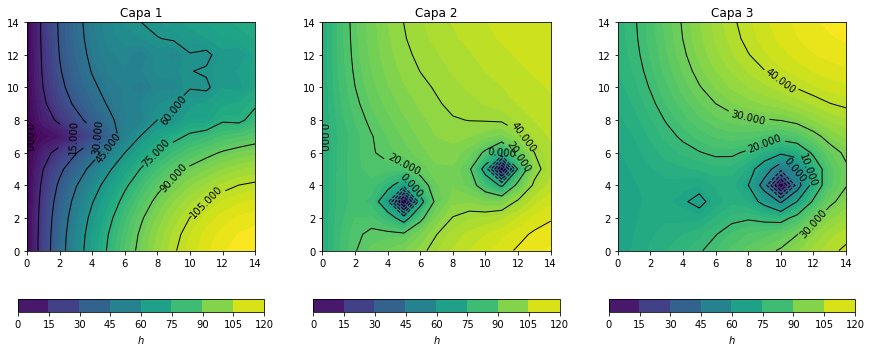

In [28]:
levels = 50
salto = 4
plt.figure(figsize=(15,6))

plt.subplot(131)
plt.contourf(head[0, :, :], levels=levels)#, extent=extent, cmap=mapa_color)
c1 = plt.contour(head[0, :, :], levels=int(levels/5), colors='black', linewidths=1.0)
plt.clabel(c1, inline=1, fontsize=10)
plt.gca().set_aspect('equal')
plt.colorbar(cf, orientation='horizontal', label='$h$')
plt.title('Capa 1')

plt.subplot(132)
plt.contourf(head[1, :, :], levels=levels)#, extent=extent, cmap=mapa_color)
c2 = plt.contour(head[1, :, :], levels=int(levels/5), colors='black', linewidths=1.0)
plt.clabel(c2, inline=1, fontsize=10)
plt.gca().set_aspect('equal')
plt.colorbar(cf, orientation='horizontal', label='$h$')
plt.title('Capa 2')

plt.subplot(133)
plt.contourf(head[2, :, :], levels=levels)#, extent=extent, cmap=mapa_color)
c3 = plt.contour(head[2, :, :], levels=int(levels/5), colors='black', linewidths=1.0)
plt.clabel(c3, inline=1, fontsize=10)
plt.gca().set_aspect('equal')
plt.colorbar(cf, orientation='horizontal', label='$h$')
plt.title('Capa 3')

### Siguiente paso:

Continuar con el ejercicio de visualización en: <a href="./MF2005-Vis1.ipynb">MF2005-Vis1 </a>

# Referencias útiles:

<a href=https://modflowpy.github.io/flopydoc/tutorials.html>Flopy Tutorials</a>

<a href=https://github.com/modflowpy/flopy>Github: Flopy</a>

- <a href=https://github.com/modflowpy/flopy/tree/develop/examples/Notebooks>flopy/examples/Notebooks/</a>

<a href=https://www2.hawaii.edu/~jonghyun/classes/S18/CEE696/>CEE 696: Optimization in Groundwater Engineering</a>
